## Task 1: Answer Question

### Roles of Generator and Discriminator in a GAN

A **Generative Adversarial Network (GAN)** consists of two competing neural networks:

#### Generator
- Purpose: **Create synthetic (fake) data** that mimics the real data distribution.
- Input: **Random noise** (latent vector).
- Goal: **Fool the discriminator** into thinking generated images are real.

#### Discriminator
- Purpose: **Classify inputs** as **real** (from dataset) or **fake** (from generator).
- Input: **Image (either real or generated)**.
- Goal: **Correctly distinguish real vs. fake images**.

---

#### Adversarial Training
- The **generator** improves by producing more realistic data.
- The **discriminator** improves by becoming better at spotting fakes.
- Over time, **both models improve together** in a balanced "zero-sum game".

When trained successfully, the generator can create **extremely realistic** images that are **indistinguishable from real ones**.

## Generate Artificial Faces with CelebA Progressive GAN Model


### Load Dependencies and Generator

In [ ]:
# Install imageio for creating animations.
!pip -q install imageio
!pip -q install scikit-image
!pip install git+https://github.com/tensorflow/docs

In [13]:
from absl import logging

import imageio
import PIL.Image
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
tf.random.set_seed(0)

import tensorflow_hub as hub
from tensorflow_docs.vis import embed
import time

try:
  from google.colab import files
except ImportError:
  pass

from IPython import display
from skimage import transform

# We could retrieve this value from module.get_input_shapes() if we didn't know
# beforehand which module we will be using.
latent_dim = 512

# Interpolates between two vectors that are non-zero and don't both lie on a
# line going through origin. First normalizes v2 to have the same norm as v1.
# Then interpolates between the two vectors on the hypersphere.
def interpolate_hypersphere(v1, v2, num_steps):
  v1_norm = tf.norm(v1)
  v2_norm = tf.norm(v2)
  v2_normalized = v2 * (v1_norm / v2_norm)

  vectors = []
  for step in range(num_steps):
    interpolated = v1 + (v2_normalized - v1) * step / (num_steps - 1)
    interpolated_norm = tf.norm(interpolated)
    interpolated_normalized = interpolated * (v1_norm / interpolated_norm)
    vectors.append(interpolated_normalized)
  return tf.stack(vectors)

# Simple way to display an image.
def display_image(image):
  image = tf.constant(image)
  image = tf.image.convert_image_dtype(image, tf.uint8)
  return PIL.Image.fromarray(image.numpy())

# Given a set of images, show an animation.
def animate(images):
  images = np.array(images)
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images)
  return embed.embed_file('./animation.gif')

logging.set_verbosity(logging.ERROR)

### Random Vector

In [14]:
progan = hub.load("https://tfhub.dev/google/progan-128/1").signatures['default']


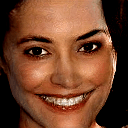

In [15]:
def interpolate_between_vectors():
  v1 = tf.random.normal([latent_dim])
  v2 = tf.random.normal([latent_dim])

  # Creates a tensor with 25 steps of interpolation between v1 and v2.
  vectors = interpolate_hypersphere(v1, v2, 50)

  # Uses module to generate images from the latent space.
  interpolated_images = progan(vectors)['default']

  return interpolated_images

interpolated_images = interpolate_between_vectors()
animate(interpolated_images)

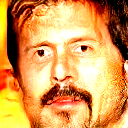

In [16]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

### Finding Closest Vector in latent space

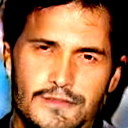

In [17]:
image_from_module_space = True  # @param { isTemplate:true, type:"boolean" }

def get_module_space_image():
  vector = tf.random.normal([1, latent_dim])
  images = progan(vector)['default'][0]
  return images

def upload_image():
  uploaded = files.upload()
  image = imageio.imread(uploaded[list(uploaded.keys())[0]])
  return transform.resize(image, [128, 128])

if image_from_module_space:
  target_image = get_module_space_image()
else:
  target_image = upload_image()

display_image(target_image)

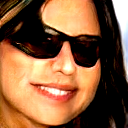

In [18]:
tf.random.set_seed(42)
initial_vector = tf.random.normal([1, latent_dim])
display_image(progan(initial_vector)['default'][0])

In [19]:
def find_closest_latent_vector(initial_vector, num_optimization_steps,
                               steps_per_image):
  images = []
  losses = []

  vector = tf.Variable(initial_vector)
  optimizer = tf.optimizers.Adam(learning_rate=0.01)
  loss_fn = tf.losses.MeanAbsoluteError(reduction="sum")

  for step in range(num_optimization_steps):
    if (step % 100)==0:
      print()
    print('.', end='')
    with tf.GradientTape() as tape:
      image = progan(vector.read_value())['default'][0]
      if (step % steps_per_image) == 0:
        images.append(image.numpy())
      target_image_difference = loss_fn(image, target_image[:,:,:3])
      # The latent vectors were sampled from a normal distribution. We can get
      # more realistic images if we regularize the length of the latent vector to
      # the average length of vector from this distribution.
      regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))

      loss = target_image_difference + regularizer
      losses.append(loss.numpy())
    grads = tape.gradient(loss, [vector])
    optimizer.apply_gradients(zip(grads, [vector]))

  return images, losses


num_optimization_steps=200
steps_per_image=5
images, loss = find_closest_latent_vector(initial_vector, num_optimization_steps, steps_per_image)


....................................................................................................
....................................................................................................

#### Plot

(0.0, 4881.15210571289)

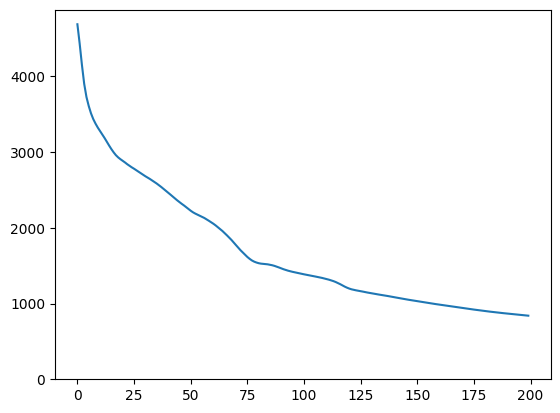

In [20]:
plt.plot(loss)
plt.ylim([0,max(plt.ylim())])

#### Comparison of Result vs Target

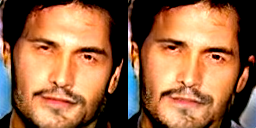

In [21]:
display_image(np.concatenate([images[-1], target_image], axis=1))

## Task 2: Create Artwork by Manipulating Latent Space (Facial Features)

### Step 1: Install Packages and Imports

In [ ]:
# Install libraries
!pip install -q imageio
!pip install -q scikit-image
!pip install git+https://github.com/tensorflow/docs

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import imageio
import glob
import os
import PIL
import tensorflow_hub as hub
from skimage import transform
from IPython import display

### Step 2: Load Pretrained GAN Model (Progressive GAN)

In [23]:
# Load pretrained Progressive GAN (ProGAN) from TensorFlow Hub
progan = hub.load('https://tfhub.dev/google/progan-128/1').signatures['default']

# Define latent space dimension
latent_dim = 512  # Latent dimension for ProGAN-128

 ### Step 3: Define Functions

In [25]:
# Interpolation function: Hypersphere interpolation
def interpolate_hypersphere(v1, v2, n_steps):
    v1_norm = v1 / tf.norm(v1)
    v2_norm = v2 / tf.norm(v2)

    dot = tf.reduce_sum(v1_norm * v2_norm)
    omega = tf.acos(dot)
    sin_omega = tf.sin(omega)

    steps = []
    for t in np.linspace(0, 1, n_steps):
        factor1 = tf.sin((1 - t) * omega) / sin_omega
        factor2 = tf.sin(t * omega) / sin_omega
        vector = factor1 * v1_norm + factor2 * v2_norm
        steps.append(vector)
    return tf.stack(steps)

# Function to animate images into a GIF
def animate(images, filename="latent_interpolation.gif"):
    images = np.clip((images + 1) / 2.0, 0, 1)  # Rescale [-1,1] to [0,1]
    images = (images * 255).astype(np.uint8)
    with imageio.get_writer(filename, mode='I') as writer:
        for img in images:
            writer.append_data(img)
    return filename

# Display single image helper
def display_image(img):
    img = (img + 1) / 2.0  # Rescale [-1,1] to [0,1]
    plt.imshow(img)
    plt.axis('off')
    plt.show()

### Step 4: Interpolation Between Two Latent Vectors

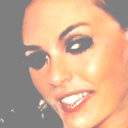

In [74]:
# Interpolate between two random latent vectors
def interpolate_between_vectors():
    v1 = tf.random.normal([latent_dim])
    v2 = tf.random.normal([latent_dim])

    interpolated_vectors = interpolate_hypersphere(v1, v2, 50)
    generated_images = progan(interpolated_vectors)['default']

    return generated_images

# Generate and visualize
interpolated_images = interpolate_between_vectors()

# Animate
animate(interpolated_images)
display.Image(filename="latent_interpolation.gif")

### Step 5: Finding Closest Vector to a Target Image

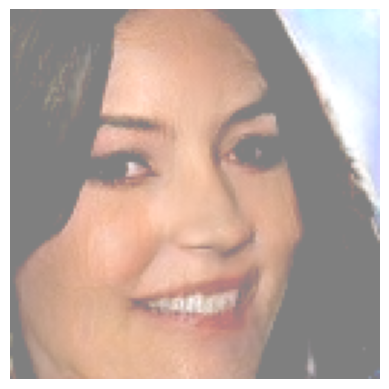

In [211]:
from google.colab import files
import io

def upload_target_image():
    uploaded = files.upload()
    image = imageio.imread(io.BytesIO(uploaded[list(uploaded.keys())[0]]))
    image = transform.resize(image, (128, 128))
    return image

# Set whether to use generated image or upload
image_from_model = True

if image_from_model:
    target_vector = tf.random.normal([1, latent_dim])
    target_image = progan(target_vector)['default'][0]
else:
    target_image = upload_target_image()

display_image(target_image)

### Step 6: Optimization (Latent Vector Search)

Step 0, Loss: 4322.8569
Step 100, Loss: 1619.2676
Step 200, Loss: 359.6121


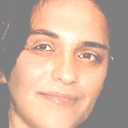

In [218]:
# Fix for uploaded image scaling
if not image_from_model:
    target_image = (target_image * 2.0) - 1.0  # Scale from [0, 1] → [-1, 1]

# Optimization function to find closest latent vector
def find_closest_latent_vector(initial_vector, target_image, steps=300, steps_per_image=5):
    images = []
    losses = []

    vector = tf.Variable(initial_vector)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    loss_fn = tf.keras.losses.MeanAbsoluteError(reduction="sum")

    for step in range(steps):
        with tf.GradientTape() as tape:
            generated_image = progan(vector.read_value())['default'][0]

            # Match shape if needed (drop alpha if exists)
            loss = loss_fn(generated_image, target_image[:,:,:3])

            # Regularize vector magnitude
            regularizer = tf.abs(tf.norm(vector) - np.sqrt(latent_dim))
            total_loss = loss + 0.1 * regularizer

        grads = tape.gradient(total_loss, [vector])
        optimizer.apply_gradients(zip(grads, [vector]))

        if step % steps_per_image == 0:
            images.append(generated_image.numpy())
            losses.append(total_loss.numpy())

        if step % 1000 == 0:
            print(f"Step {step}, Loss: {total_loss.numpy():.4f}")

    return images, losses


# Run optimization
initial_vector = tf.random.normal([1, latent_dim])
optimized_images, loss_curve = find_closest_latent_vector(initial_vector, target_image)

# Save GIF animation of optimization steps
animate(np.stack(optimized_images), filename="optimization.gif")
display.Image(filename="optimization.gif")


## Task 3: Create Any Artwork (using other GANs)

use StyleGAN2 with pretrained weights to generate realistic, high-quality artworks.

### Installation

In [ ]:
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

### Download Pretrain Weights

In [ ]:
# FFHQ 1024x1024 config-f weights from NVIDIA's original StyleGAN2 release
!wget https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl

### Generate Random Artwork

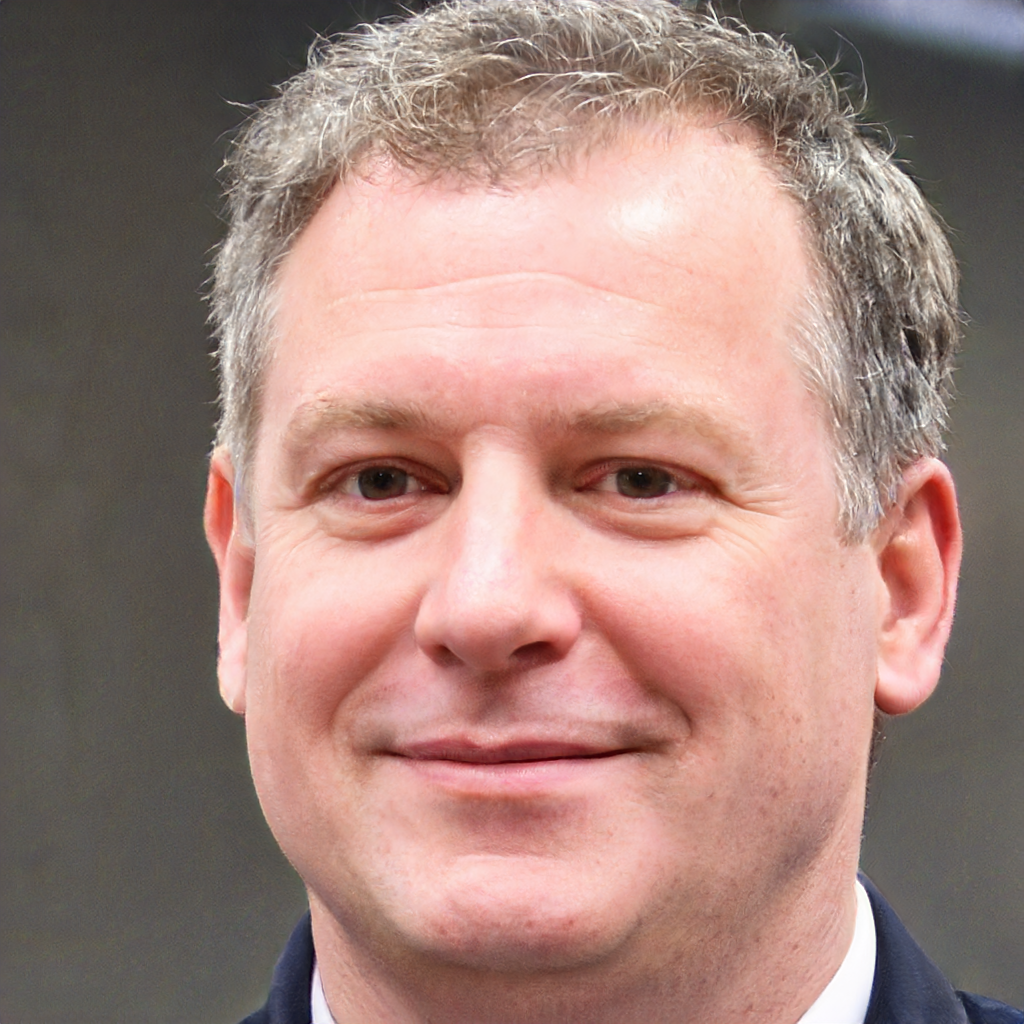

In [20]:
import torch
import legacy
import numpy as np
import PIL.Image
import dnnlib

# Load network
network_path = 'ffhq.pkl'
device = torch.device('cpu')

with open(network_path, 'rb') as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device)  # Load generator

# Generate image
z = torch.randn([1, G.z_dim], device=device)  # Latent vector
label = torch.zeros([1, G.c_dim], device=device)  # No conditional label
img = G(z, label, truncation_psi=0.7, noise_mode='const')

# Convert and save image
img = (img.clamp(-1, 1) + 1) / 2  # Normalize to [0,1]
img = (img * 255).to(torch.uint8)
img = img[0].permute(1, 2, 0).cpu().numpy()
PIL.Image.fromarray(img, 'RGB').save('stylegan2_art.png')
PIL.Image.open('stylegan2_art.png')